# 🧠 Построение деревьев решений

В этом ноутбуке мы вручную изучим, как дерево решений "принимает решения".

Мы:
- создадим простой датафрейм;
- разобьём данные по категориям;
- оценим разделяющие вопросы с помощью метрик: **точность**, **индекс Джини** и **энтропия**;
- применим scikit-learn для построения и визуализации деревьев решений;

## 📥 Импорт библиотек

In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.decimal_to_fraction import decimal_to_fraction
from utils.metrics import counts, gini_one_group, entropy_one_group
from utils.evaluate_thresholds import evaluate_thresholds

from utils.plot_points import plot_points
from utils.plot_dt_decision_boundary import plot_dt_decision_boundary

from sklearn import tree
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor


warnings.filterwarnings('ignore')

# Установка seed для воспроизводимости случайных результатов
random.seed(0)

## 📄 Создание и первичный анализ данных

In [2]:
data = {
    'Платформа': ['iPhone', 'iPhone', 'Android', 'iPhone', 'Android', 'Android'],
    'Возраст, лет': [15, 25, 32, 35, 12, 14],
    'Приложение': ['Счетчик атомов', 'Австраломат', 'Карта ульев', 'Австраломат', 'Счетчик атомов', 'Счетчик атомов']
}

df = pd.DataFrame(data)
df

,Платформа,"Возраст, лет",Приложение
0,iPhone,15,Счетчик атомов
1,iPhone,25,Австраломат
2,Android,32,Карта ульев
3,iPhone,35,Австраломат
4,Android,12,Счетчик атомов
5,Android,14,Счетчик атомов


# Первый шаг построения модели — задать наилучший вопрос

In [3]:
# Добавляем возрастную группу
df['Возрастная группа'] = ['Молодые' if age < 20 else 'Взрослые' for age in df['Возраст, лет']]

# Переупорядочиваем колонки для лучшей читаемости
df = df[['Платформа', 'Возраст, лет', 'Возрастная группа', 'Приложение']]

df

,Платформа,"Возраст, лет",Возрастная группа,Приложение
0,iPhone,15,Молодые,Счетчик атомов
1,iPhone,25,Взрослые,Австраломат
2,Android,32,Взрослые,Карта ульев
3,iPhone,35,Взрослые,Австраломат
4,Android,12,Молодые,Счетчик атомов
5,Android,14,Молодые,Счетчик атомов


## ❓Первый вопрос: «iPhone или Android используется?»

In [4]:
# 1. Разделяем по платформе
iphone_users = df[df['Платформа'] == 'iPhone']
android_users = df[df['Платформа'] == 'Android']

# 2. Анализируем распределение приложений
print("Распределение для iPhone:")
print(iphone_users['Приложение'].value_counts())

print("\nРаспределение для Android:")
print(android_users['Приложение'].value_counts())

Распределение для iPhone:
Приложение
Австраломат       2
Счетчик атомов    1
Name: count, dtype: int64

Распределение для Android:
Приложение
Счетчик атомов    2
Карта ульев       1
Name: count, dtype: int64


## ❓Второй вопрос: «Пользователь молодой или взрослый?»

In [5]:
# 1. Разделяем по возрастной группе
young_users = df[df['Возрастная группа'] == 'Молодые']
adult_users = df[df['Возрастная группа'] == 'Взрослые']

# 2. Анализируем распределение приложений
print("Распределение для молодых:")
print(young_users['Приложение'].value_counts())

print("\nРаспределение для взрослых:")
print(adult_users['Приложение'].value_counts())

Распределение для молодых:
Приложение
Счетчик атомов    3
Name: count, dtype: int64

Распределение для взрослых:
Приложение
Австраломат    2
Карта ульев    1
Name: count, dtype: int64


# 🧮 Метрики: Джини и Энтропия

In [6]:
elements = ['A', 'A', 'A', 'C', 'B', 'C']
print(f'Количество каждого класса в списке: {counts(elements)}')
print(f'Индекс Джини: {gini_one_group(elements)} ({decimal_to_fraction(gini_one_group(elements))})')
print(f'Энтропия: {entropy_one_group(elements)} ({decimal_to_fraction(entropy_one_group(elements))})')

Количество каждого класса в списке: [3, 2, 1]
Индекс Джини: 0.6111111111111112 (11/18)
Энтропия: 1.4591479170272448 (834065/571611)


## ✂ Разбиение на группы + метрики

In [7]:
for i in range(len(elements)):
    left = elements[:i]
    right = elements[i:]
    print(left, right)
    
    weighted_gini = 1 / len(elements) * (gini_one_group(left) * len(left) + gini_one_group(right) * len(right))
    print(f"Взвешенный Джини: {weighted_gini} ({decimal_to_fraction(weighted_gini)})")
    
    weighted_entropy = 1 / len(elements) * (entropy_one_group(left) * len(left) + entropy_one_group(right) * len(right))
    print(f"Взвешенная энтропия: {weighted_entropy} ({decimal_to_fraction(weighted_entropy)}) \n")

[] ['A', 'A', 'A', 'C', 'B', 'C']
Взвешенный Джини: 0.6111111111111112 (11/18)
Взвешенная энтропия: 1.4591479170272446 (834065/571611) 

['A'] ['A', 'A', 'C', 'B', 'C']
Взвешенный Джини: 0.5333333333333333 (8/15)
Взвешенная энтропия: 1.268273412406135 (932635/735358) 

['A', 'A'] ['A', 'C', 'B', 'C']
Взвешенный Джини: 0.41666666666666663 (5/12)
Взвешенная энтропия: 1.0 (1) 

['A', 'A', 'A'] ['C', 'B', 'C']
Взвешенный Джини: 0.2222222222222222 (2/9)
Взвешенная энтропия: 0.4591479170272448 (262454/571611) 

['A', 'A', 'A', 'C'] ['B', 'C']
Взвешенный Джини: 0.41666666666666663 (5/12)
Взвешенная энтропия: 0.8741854163060886 (499694/571611) 

['A', 'A', 'A', 'C', 'B'] ['C']
Взвешенный Джини: 0.4666666666666667 (7/15)
Взвешенная энтропия: 1.142458828712224 (749429/655979) 



# 🧠 Поиск наилучшего порога

**💡 Что делает следующий код?**

Он превращает числовой признак (например, «Возраст») в серию вопросов вида:

> «Возраст < 18.5?»,  
> «Возраст < 32.0?» и т.д.,

и **оценивает, насколько такие вопросы хорошо разделяют выборку** по классу (`target_col`) с помощью:

* Accuracy (точность),
* Gini (нечистота),
* Entropy (неопределённость).

- Метрики показывают: наилучшее разделение даёт самая низкая взвешенная энтропия и индекс Джини.
- Подобный подход можно масштабировать на все числовые признаки для обучения дерева решений.

In [8]:
results_df = evaluate_thresholds(df, feature_col='Возраст, лет', target_col='Приложение', precision=2)

display(results_df)

,Вопрос,Первый набор (да),Второй набор (нет),Метки,Взвешенная достоверность,Взвешенный индекс примесей Джини,Взвешенная энтропия
0,"Возраст, лет < 11.0?",[],"[15, 25, 32, 35, 12, 14]","[[], [Счетчик атомов, Австраломат, Карта ульев...",0.50,0.61,1.46
1,"Возраст, лет < 13.0?",[12],"[15, 25, 32, 35, 14]","[[Счетчик атомов], [Счетчик атомов, Австралома...",0.50,0.53,1.27
2,"Возраст, лет < 14.5?","[12, 14]","[15, 25, 32, 35]","[[Счетчик атомов, Счетчик атомов], [Счетчик ат...",0.67,0.42,1.00
3,"Возраст, лет < 20.0?","[15, 12, 14]","[25, 32, 35]","[[Счетчик атомов, Счетчик атомов, Счетчик атом...",0.83,0.22,0.46
4,"Возраст, лет < 28.5?","[15, 25, 12, 14]","[32, 35]","[[Счетчик атомов, Австраломат, Счетчик атомов,...",0.67,0.42,0.87
5,"Возраст, лет < 33.5?","[15, 25, 32, 12, 14]",[35],"[[Счетчик атомов, Австраломат, Карта ульев, Сч...",0.67,0.47,1.14
6,"Возраст, лет < 36.0?","[15, 25, 32, 35, 12, 14]",[],"[[Счетчик атомов, Австраломат, Карта ульев, Ав...",0.50,0.61,1.46


# Использование Scikit-Learn. Учимся строить дерево решений (App_recommendations)

In [9]:
# Создание DataFrame с данными о пользователях приложений
app_dataset = pd.DataFrame({
    'Platform': ['iPhone','iPhone','Android','iPhone','Android','Android'],  # Платформа устройства
    'Age': [15, 25, 32, 35, 12, 14],  # Возраст пользователей
    'App': ['Atom Count', 'Check Mate Mate', 'Beehive Finder', 'Check Mate Mate', 'Atom Count', 'Atom Count']})  # Названия приложений

# Вывод DataFrame на экран
app_dataset

,Platform,Age,App
0,iPhone,15,Atom Count
1,iPhone,25,Check Mate Mate
2,Android,32,Beehive Finder
3,iPhone,35,Check Mate Mate
4,Android,12,Atom Count
5,Android,14,Atom Count


## С one-hot кодированием категориальных признаков (возраст как бинарные признаки)

In [10]:
# Создание one-hot encoded версии данных (преобразование категориальных признаков в бинарные)
app_dataset_one_hot = pd.DataFrame(
    {'Platform_iPhone':[1,1,0,1,0,0],     # Бинарный признак для iPhone
     'Platform_Android':[0,0,1,0,1,1],    # Бинарный признак для Android
     'Age_Young':[1,0,0,0,1,1],           # Бинарный признак для молодого возраста
     'Age_Adult':[0,1,1,1,0,0],           # Бинарный признак для взрослого возраста
     'App_Atom_Count':[1,0,0,0,1,1],      # Бинарный признак для приложения Atom Count
     'App_Beehive_Finder':[0,0,1,0,0,0],  # Бинарный признак для приложения Beehive Finder
     'App_Check_Mate_Mate':[0,1,0,1,0,0]}) # Бинарный признак для приложения Check Mate Mate

# Вывод one-hot encoded данных на экран
app_dataset_one_hot

,Platform_iPhone,Platform_Android,Age_Young,Age_Adult,App_Atom_Count,App_Beehive_Finder,App_Check_Mate_Mate
0,1,0,1,0,1,0,0
1,1,0,0,1,0,0,1
2,0,1,0,1,0,1,0
3,1,0,0,1,0,0,1
4,0,1,1,0,1,0,0
5,0,1,1,0,1,0,0


In [11]:
# Выделение признаков (X) - платформа и возраст в one-hot кодировке
X = app_dataset_one_hot[['Platform_iPhone','Platform_Android','Age_Adult','Age_Young']]

# Выделение целевых переменных (y) - приложения в one-hot кодировке
y = app_dataset_one_hot[['App_Atom_Count','App_Beehive_Finder','App_Check_Mate_Mate']]

In [12]:
# Создание экземпляра классификатора дерева решений
dt = DecisionTreeClassifier()

# Обучение модели на данных X и y
dt.fit(X,y)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [13]:
# Оценка точности модели на обучающих данных (1.0 означает 100% точность)
dt.score(X,y)

1.0

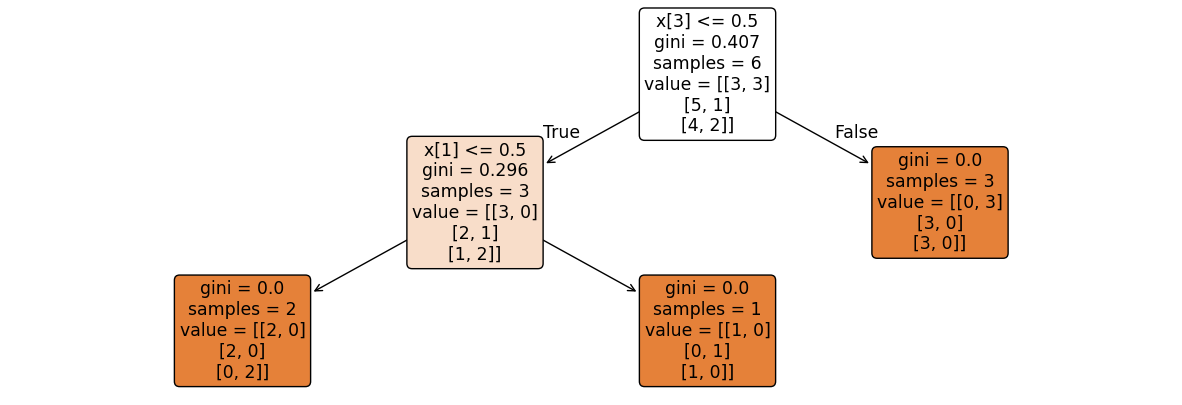

In [14]:
# Визуализация дерева решений
plt.figure(figsize=(15, 5))  # Увеличиваем размер изображения
tree.plot_tree(dt, rounded=True, filled=True)
plt.show()

- **gini** (**Джини**) - *индекс примесей Джини меток в этом узле*
- **samples** (**элементы**) - *кол-во точек данных (элементов), соответсвтующих этому узлу*
- **value** (**значение**) - *кол-во точек данных каждой из двух меток в этом узле*

## С числовым представлением возраста (не one-hot)

In [15]:
# Создание нового DataFrame с числовым представлением возраста (не one-hot)
app_dataset = pd.DataFrame({
    'Platform_iPhone':[1,1,0,1,0,0],      # Бинарный признак для iPhone
    'Platform_Android':[0,0,1,0,1,1],     # Бинарный признак для Android
    'Age': [15, 25, 32, 35, 12, 14],      # Возраст как числовой признак
    'App': ['Atom Count', 'Check Mate Mate', 'Beehive Finder', 'Check Mate Mate', 'Atom Count', 'Atom Count']})

# Вывод DataFrame на экран
app_dataset

,Platform_iPhone,Platform_Android,Age,App
0,1,0,15,Atom Count
1,1,0,25,Check Mate Mate
2,0,1,32,Beehive Finder
3,1,0,35,Check Mate Mate
4,0,1,12,Atom Count
5,0,1,14,Atom Count


In [16]:
# Выделение признаков: возраст и платформа
features = app_dataset[['Age','Platform_iPhone','Platform_Android']]

# Выделение целевой переменной - названия приложений
labels = app_dataset['App']

In [17]:
# Создание нового экземпляра классификатора дерева решений
app_model = DecisionTreeClassifier()

# Обучение модели на признаках и целевой переменной
app_model.fit(features, labels)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [18]:
# Оценка точности модели на обучающих данных
app_model.score(features, labels)

1.0

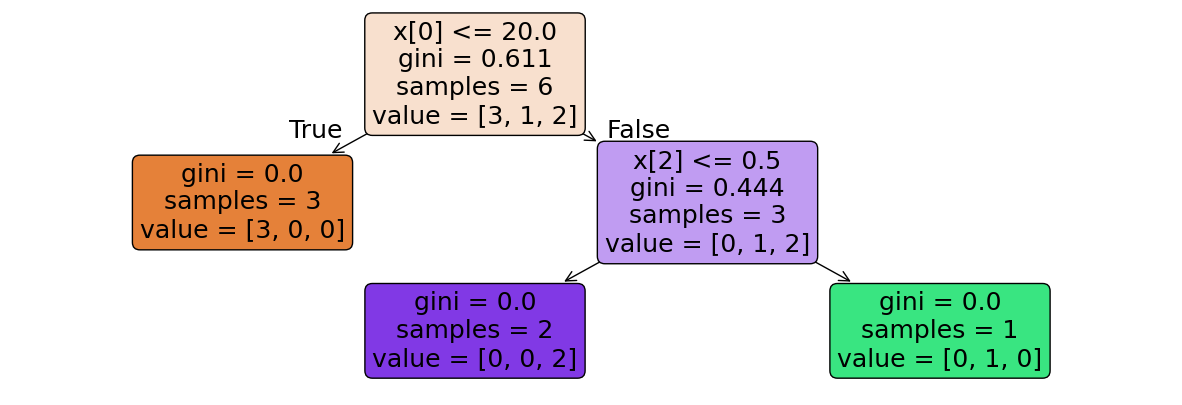

In [19]:
# Визуализация нового дерева решений
plt.figure(figsize=(15, 5))  # Увеличиваем размер изображения
tree.plot_tree(app_model, rounded=True, filled=True)
plt.show()

- **gini** (**Джини**) - *индекс примесей Джини меток в этом узле*
- **samples** (**элементы**) - *кол-во точек данных (элементов), соответсвтующих этому узлу*
- **value** (**значение**) - *кол-во точек данных каждой из трёх меток в этом узле*

# Использование Scikit-Learn. Графическая граница дервеьев решений

- Как построить дерево решений геометрически (в двух измерениях)
- Как закодировать дерево решений в популярном пакете машинного обучения Scikit-Learn.

In [20]:
# Создание набора данных в виде таблицы (DataFrame) с тремя столбцами:
# x_0 - первая признаковая переменная
# x_1 - вторая признаковая переменная
# y - целевая переменная (метки классов 0 и 1)
dataset = pd.DataFrame({
    'x_0':[7,3,2,1,2,4,1,8,6,7,8,9],
    'x_1':[1,2,3,5,6,7,9,10,5,8,4,6],
    'y': [0,0,0,0,0,0,1,1,1,1,1,1]})

# Вывод созданного набора данных на экран
dataset

,x_0,x_1,y
0,7,1,0
1,3,2,0
2,2,3,0
3,1,5,0
4,2,6,0
5,4,7,0
6,1,9,1
7,8,10,1
8,6,5,1
9,7,8,1


In [21]:
# Выделение признаков (features) - столбцы x_0 и x_1
features = dataset[['x_0', 'x_1']]

# Выделение меток (labels) - столбец y
labels = dataset['y']


# Установим параметры для графиков
figsize = (12, 4)
xlim=(0, 10)
ylim=(0, 11)

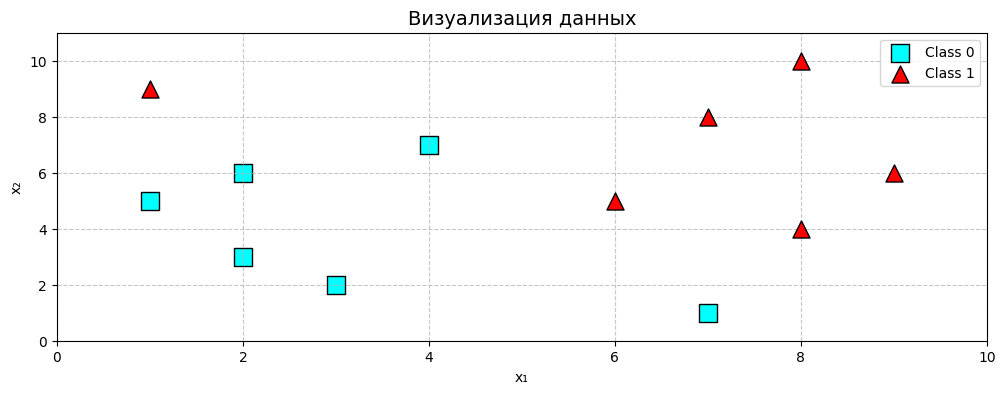

In [22]:
# Создаем график
plt.figure(figsize=figsize)

plot_points(features, labels, 
            point_size=150,
            xlim=xlim,
            ylim=ylim)

# Настраиваем график
plt.title('Визуализация данных', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## Построение дерева решений с использованием критерия Джини (Gini index)

In [23]:
decision_tree = DecisionTreeClassifier()  # Создание модели дерева решений
decision_tree.fit(features, labels)  # Обучение модели на данных

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
# Оценка точности модели на обучающих данных
decision_tree.score(features, labels)  

1.0

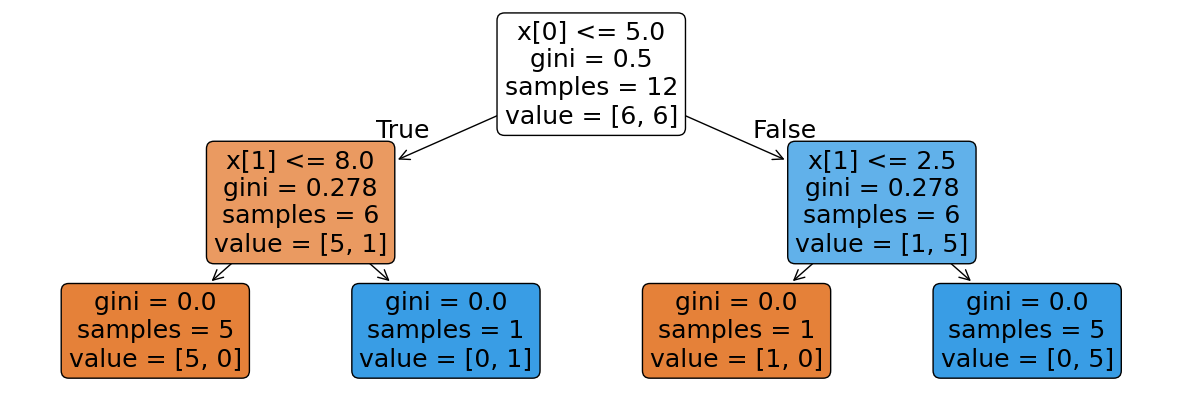

In [25]:
# Отображение структуры построенного дерева
plt.figure(figsize=(15, 5))  # Увеличиваем размер изображения
tree.plot_tree(decision_tree, rounded=True, filled=True)
plt.show()

- **gini** (**Джини**) - *индекс примесей Джини меток в этом узле*
- **samples** (**элементы**) - *кол-во точек данных (элементов), соответсвтующих этому узлу*
- **value** (**значение**) - *кол-во точек данных каждой из двух меток в этом узле*

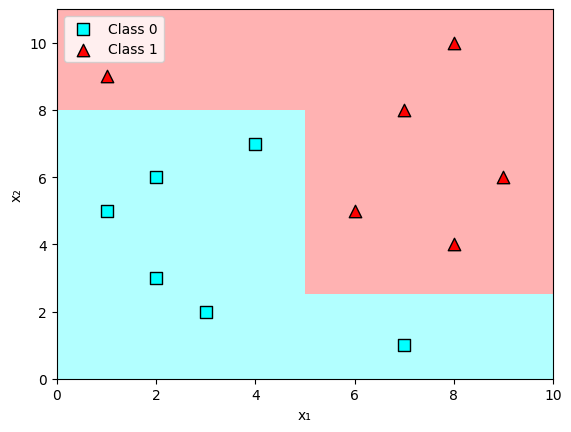

In [26]:
# Визуализация границы решения классификатора
plot_dt_decision_boundary(decision_tree, features, labels)
plt.show()

## Построение дерева решений с использованием критерия энтропии

In [27]:
decision_tree_entropy = DecisionTreeClassifier(criterion='entropy')  # Создание модели с другим критерием
decision_tree_entropy.fit(features, labels)  # Обучение модели

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
decision_tree_entropy.score(features, labels)  # Оценка точности

1.0

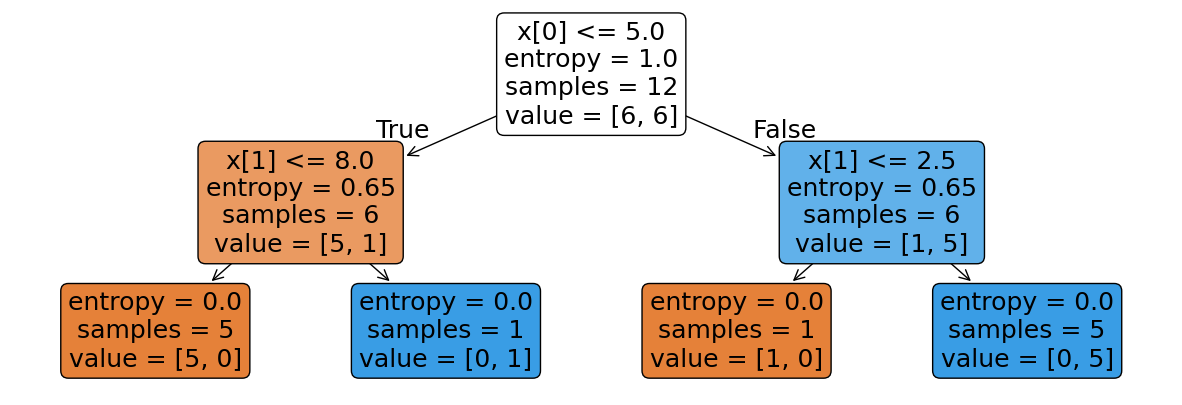

In [29]:
# Отображение структуры дерева, построенного по энтропии
plt.figure(figsize=(15, 5))  # Увеличиваем размер изображения
tree.plot_tree(decision_tree_entropy, rounded=True, filled=True)
plt.show()

- **entropy** (**"Энтропия**) - *энтропия меток в этом узле*
- **samples** (**элементы**) - *кол-во точек данных (элементов), соответсвтующих этому узлу*
- **value** (**значение**) - *кол-во точек данных каждой из двух меток в этом узле*

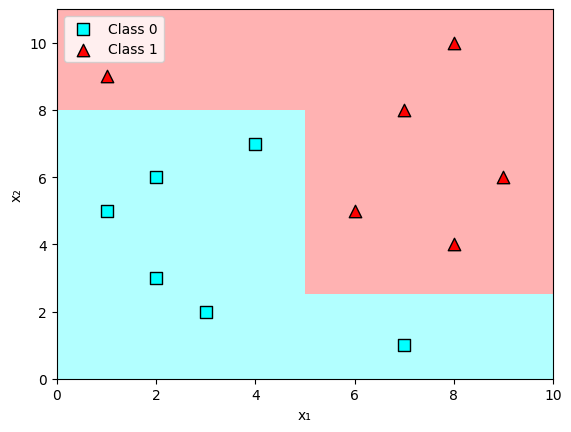

In [30]:
# Визуализация разделяющей границы для дерева с критерием энтропии
plot_dt_decision_boundary(decision_tree_entropy, features, labels)
plt.show()

# Построение дерева решений с максимальной глубиной 1 (одно разделение)

In [31]:
decision_tree_depth_1 = DecisionTreeClassifier(max_depth=1)  # Ограничение глубины дерева
decision_tree_depth_1.fit(features, labels)  # Обучение модели

,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [32]:
decision_tree_depth_1.score(features, labels)  # Оценка точности

0.8333333333333334

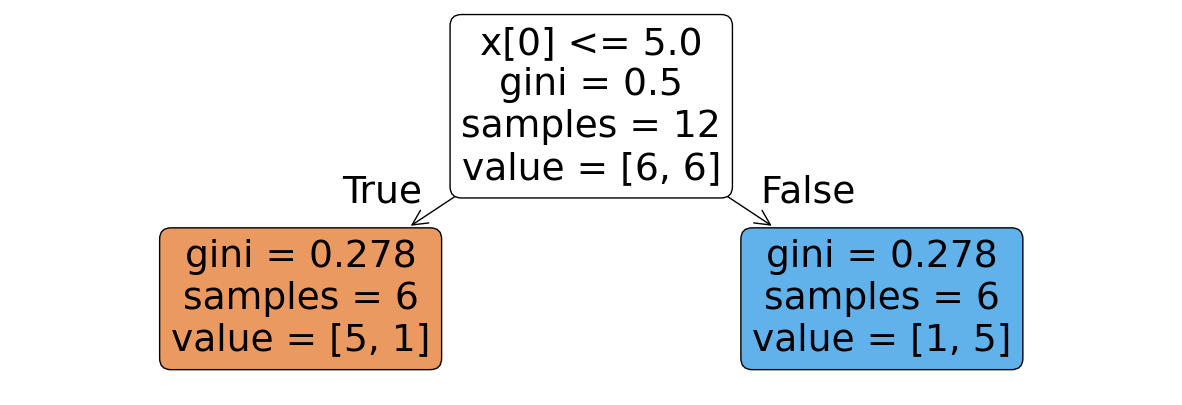

In [33]:
# Визуализация разделяющей границы для дерева глубины 1 (вертикальная или горизонтальная линия)
plt.figure(figsize=(15, 5))  # Увеличиваем размер изображения
tree.plot_tree(decision_tree_depth_1, rounded=True, filled=True)
plt.show()

- **gini** (**Джини**) - *индекс примесей Джини меток в этом узле*
- **samples** (**элементы**) - *кол-во точек данных (элементов), соответсвтующих этому узлу*
- **value** (**значение**) - *кол-во точек данных каждой из двух меток в этом узле*

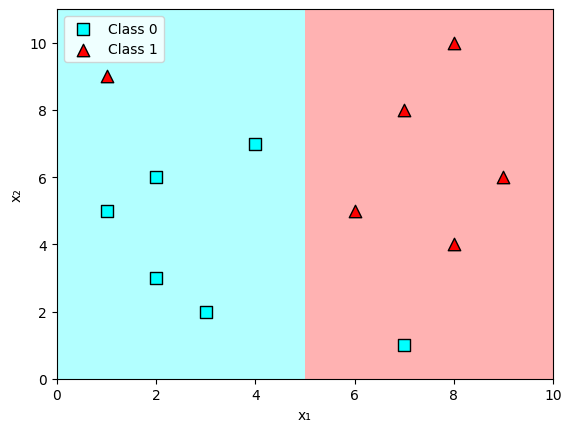

In [34]:
# Отображение структуры дерева глубины 1
plot_dt_decision_boundary(decision_tree_depth_1, features, labels)
plt.show()

# Реальное применение. Моделирование приема студентов с помощью Scikit-Learn

Здесь мы используем деревья решений для построения модели, которая прогнозирует поступление в аспирантуру.   

Набор данных содержит следующие **признаки**:  
- **оценка GRE** — *число до 340*;
- **оценка TOEFL** — *число до 120*;
- **рейтинг университета** — *число от 1 до 5*;
- **убедительность заявления о целях (SOP)** — *число от 1 до 5*;
- **средний балл бакалавриата (CGPA)** — *число от 1 до 10*;
- **убедительность рекомендательного письма (LOR)** — *число от 1 до 5*;
- **опыт исследований** — *логическая переменная (0 или 1)*.

**Метки в наборе данных** — это вероятность поступления, которая представляет собой число от 0 до 1.  
Чтобы получить двоичные метки, мы будем считать каждого студента с шансом 0,75 или выше принятым, а любого другого — непринятым.

In [35]:
# Загрузка датасета из CSV-файла 'Admission_Predict.csv' 
# index_col=0 означает, что первый столбец будет использован как индекс
data = pd.read_csv('data/Admission_Predict.csv', index_col=0)
data

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1,0.82
397,325,107,3,3.0,3.5,9.11,1,0.84
398,330,116,4,5.0,4.5,9.45,1,0.91


In [36]:
# Создание нового столбца 'Admitted' (Поступил), который будет True, 
# если Chance of Admit (Шанс поступления) >= 0.75, иначе False
data['Admitted'] = data['Chance of Admit'] >= 0.75

# Удаление столбца 'Chance of Admit', так как он больше не нужен
data = data.drop(['Chance of Admit'], axis=1)

data

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Admitted
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,True
2,324,107,4,4.0,4.5,8.87,1,True
3,316,104,3,3.0,3.5,8.00,1,False
4,322,110,3,3.5,2.5,8.67,1,True
5,314,103,2,2.0,3.0,8.21,0,False
...,...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1,True
397,325,107,3,3.0,3.5,9.11,1,True
398,330,116,4,5.0,4.5,9.45,1,True


## Разделение данных на признаки (features) и целевую переменную (labels)

Scikit-Learn требует, чтобы мы вводили признаки и метки по отдельности

In [37]:
# Признаки - все столбцы кроме 'Admitted'
features = data.drop(['Admitted'], axis=1)

# Целевая переменная - столбец 'Admitted'
labels = data['Admitted']

In [38]:
# Создание модели дерева решений
dt = DecisionTreeClassifier()

# Обучение модели на данных (features - признаки, labels - целевая переменная)
dt.fit(features, labels)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [39]:
# Предсказание для первых 5 записей
dt.predict(features[0:5])

array([ True,  True, False,  True, False])

In [40]:
# Оценка точности модели на обучающих данных
dt.score(features, labels)

1.0

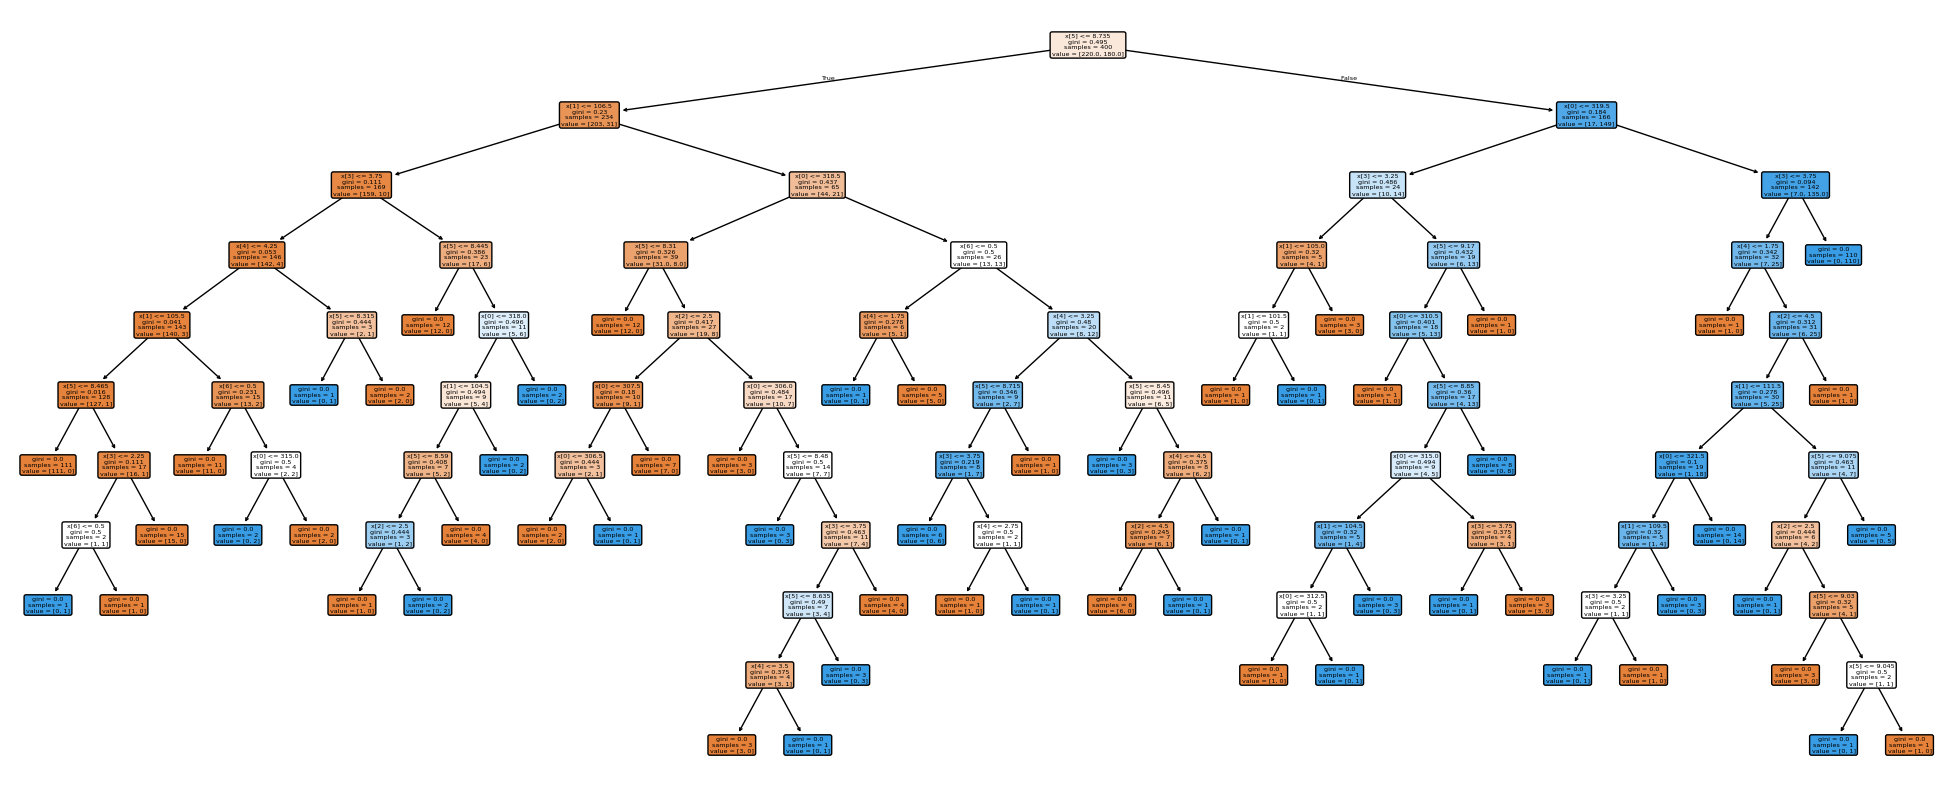

In [41]:
# Визуализация дерева
plt.figure(figsize=(25, 10))  # Увеличиваем размер изображения
tree.plot_tree(dt, rounded=True, filled=True)
plt.show()

# Создание другой модели дерева решений с ограничениями для уменьшения переобучения

In [42]:
# max_depth=3 - максимальная глубина 3
# min_samples_leaf=10 - минимальное количество образцов в листе 10
# min_samples_split=10 - минимальное количество образцов для разделения узла 10
dt_smaller = DecisionTreeClassifier(max_depth=3, min_samples_leaf=10, min_samples_split=10)

# Обучение новой модели
dt_smaller.fit(features, labels)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,10
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [43]:
# Оценка точности новой модели
dt_smaller.score(features, labels)

0.885

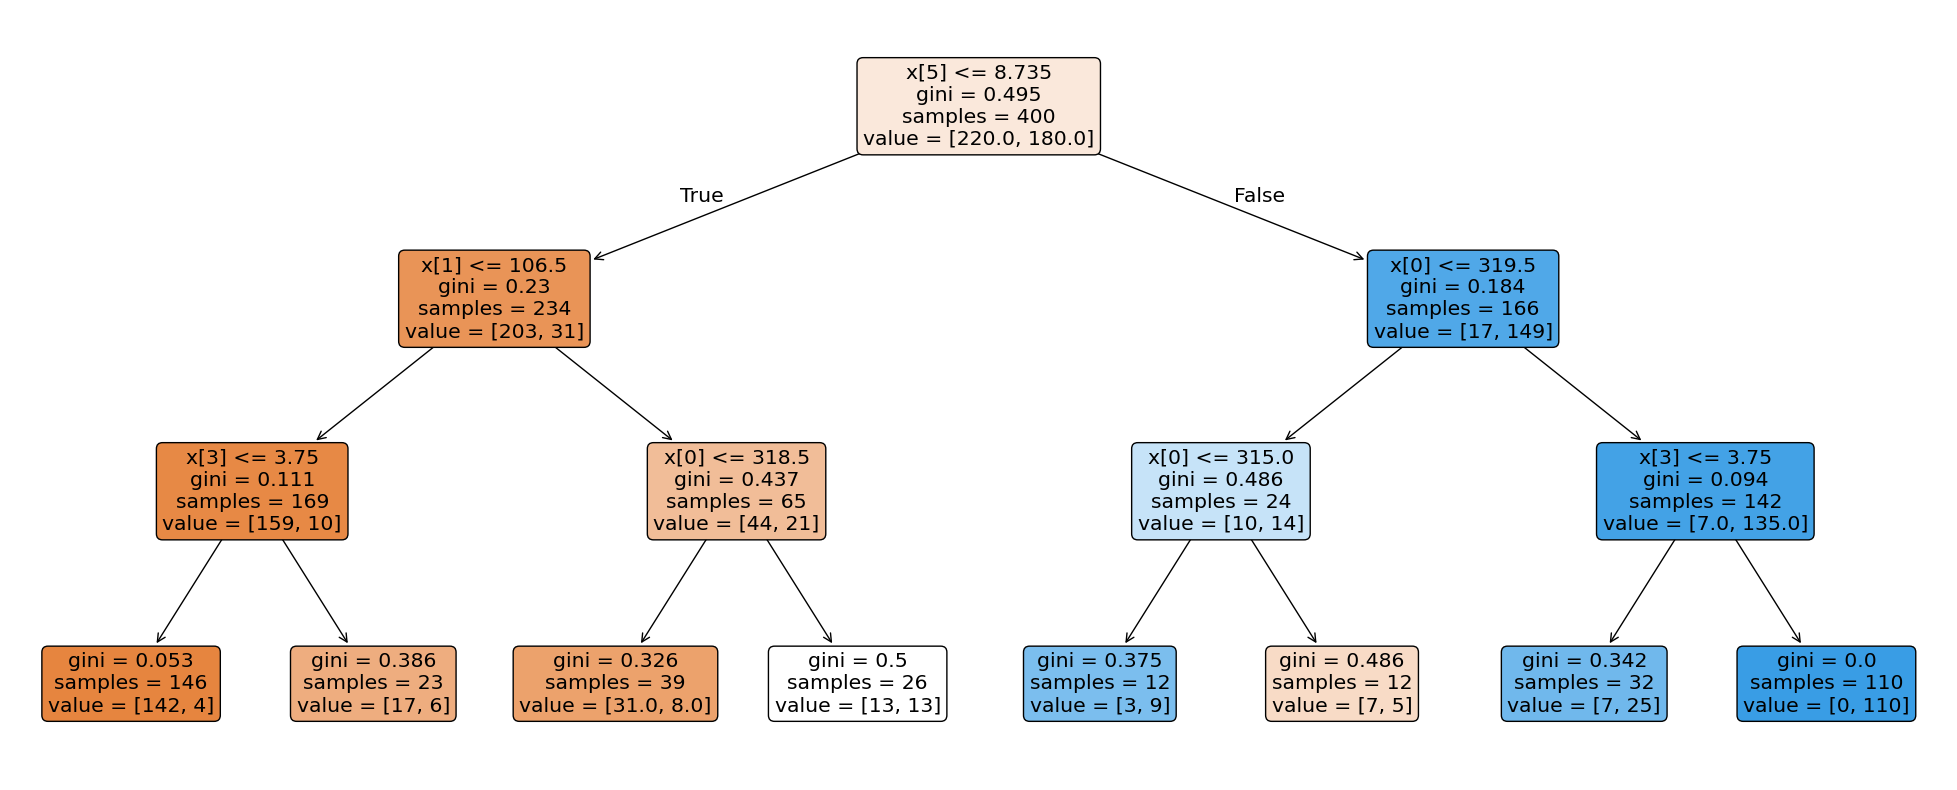

In [44]:
# Визуализация дерева
plt.figure(figsize=(25, 10))  # Увеличиваем размер изображения
tree.plot_tree(dt_smaller, rounded=True, filled=True)
plt.show()

In [45]:
# Использование модели для предсказания на новых данных
# Вернет True, так как модель предсказывает поступление
dt_smaller.predict([[320, 110, 3, 4.0, 3.5, 8.9, 0]])

array([ True])

In [46]:
# Вернет False, так как модель предсказывает непоступление
dt_smaller.predict([[320, 110, 3, 4.0, 3.5, 8.0, 0]])

array([False])

## Обучение дерева решений с использованием только двух признаков

In [47]:
# Создание нового датасета только с двумя признаками: GRE Score и TOEFL Score
exams = data[['GRE Score', 'TOEFL Score']]

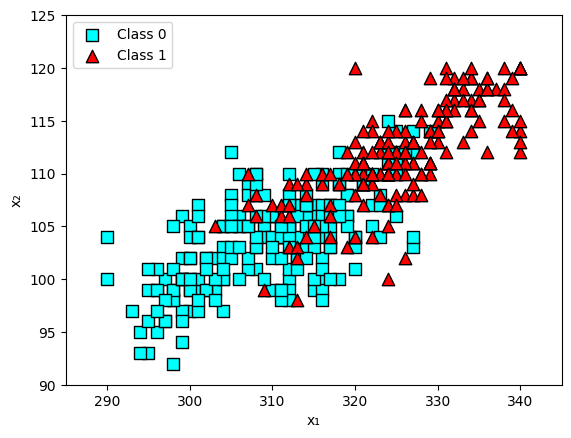

In [48]:
# Создаем новый DataFrame в нужном формате для dec_trees_plot_points
plot_data = pd.DataFrame({
    'x_0': exams['GRE Score'],  # Первый признак (GRE) -> x_0
    'x_1': exams['TOEFL Score'],  # Второй признак (TOEFL) -> x_1
    'y': labels.astype(int)  # Метки (Admitted) -> y, преобразуем bool в int
})

# Выделение признаков (features) - столбцы x_0 и x_1
features = plot_data[['x_0', 'x_1']]

# Выделение меток (labels) - столбец y
labels = plot_data['y']

# Визуализация точек (по двум признакам) с цветами по меткам (Admitted)
plot_points(features, labels, xlim=(285, 345), ylim=(90, 125))
plt.show()

In [49]:
# Создание и обучение дерева глубины 2 для двух признаков
dt_exams = DecisionTreeClassifier(max_depth=2)
dt_exams.fit(exams, labels)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


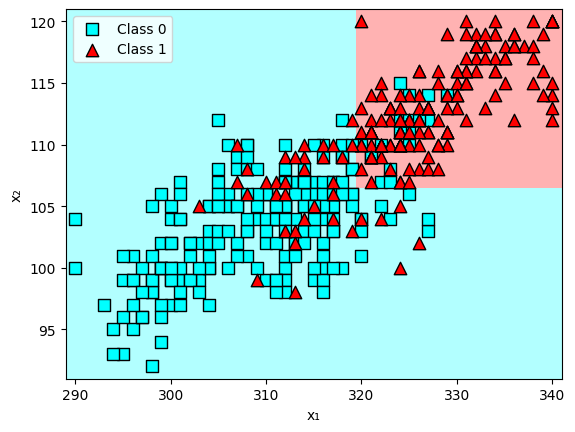

In [50]:
# Визуализация модели (разделяющей границы) для дерева глубины 2
plot_dt_decision_boundary(dt_exams, exams, labels)
plt.show()

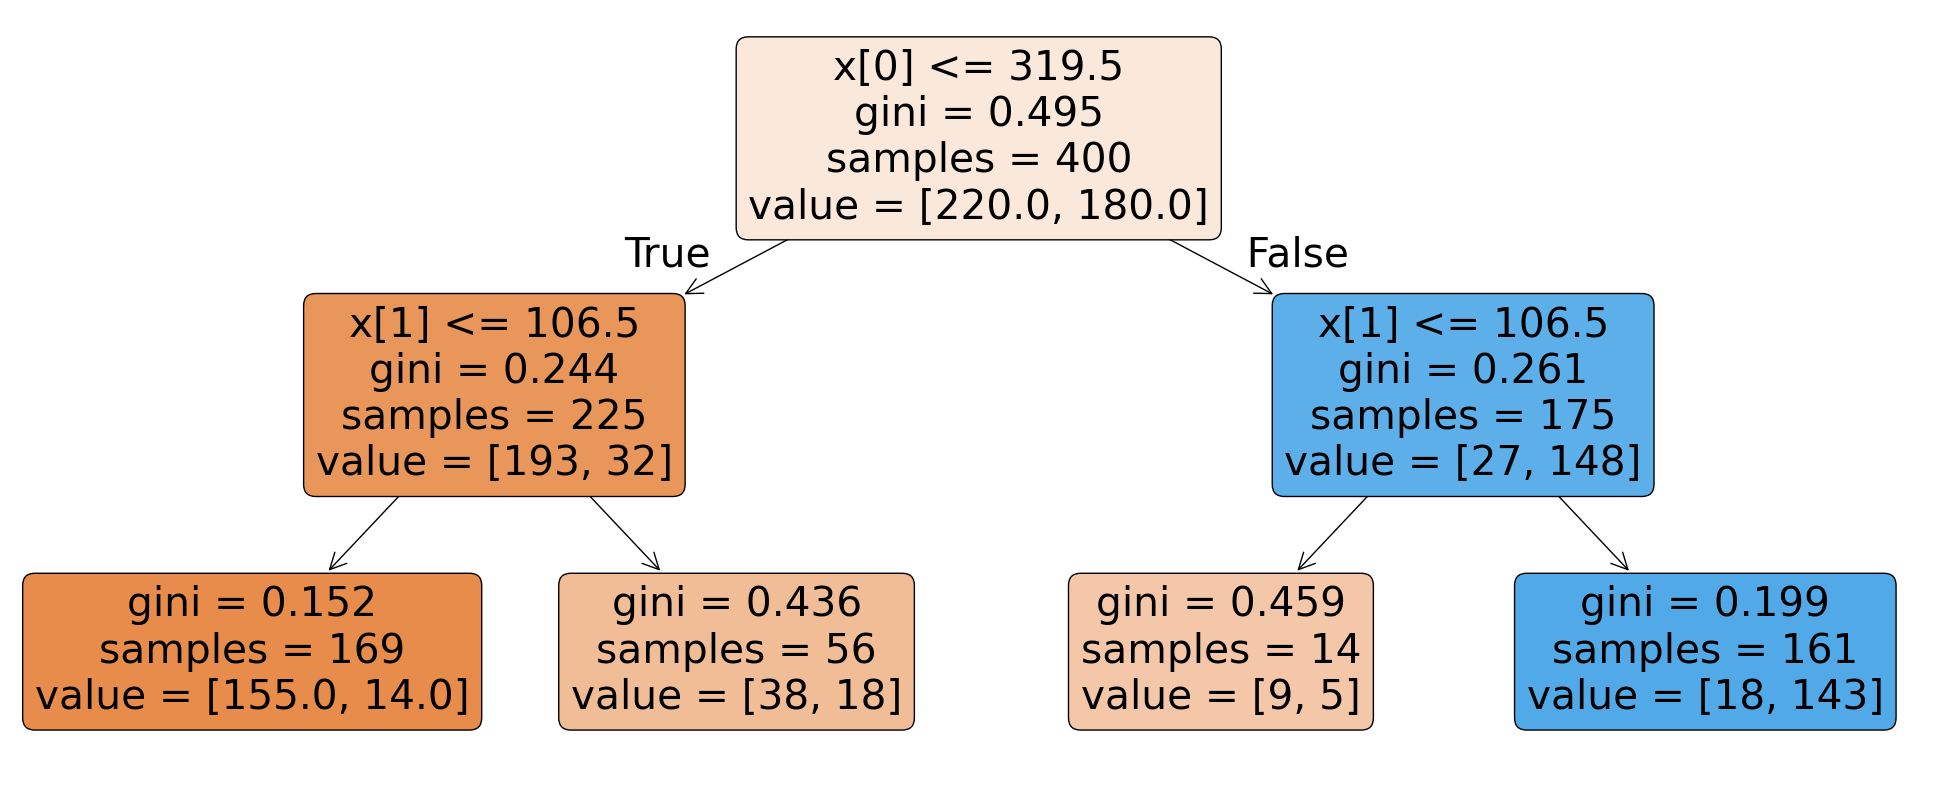

In [51]:
# Визуализация дерева глубины 2
plt.figure(figsize=(25, 10))  # Увеличиваем размер изображения
tree.plot_tree(dt_exams, rounded=True, filled=True)
plt.show()

## Создание и обучение более простого дерева (глубины 1)

In [52]:
simpler_dt_exams = DecisionTreeClassifier(max_depth=1)
simpler_dt_exams.fit(exams, labels)

,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


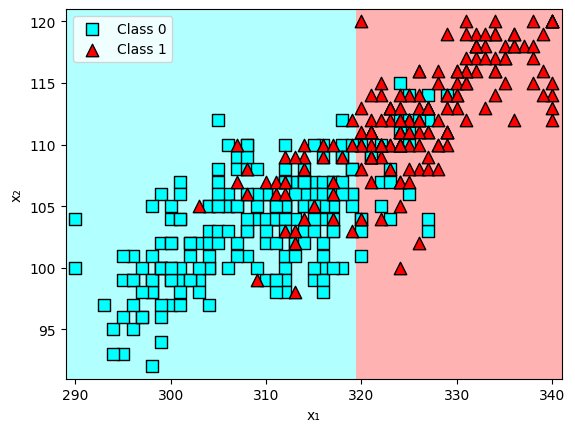

In [53]:
# Визуализация модели для дерева глубины 1
plot_dt_decision_boundary(simpler_dt_exams, exams, labels)
plt.show()

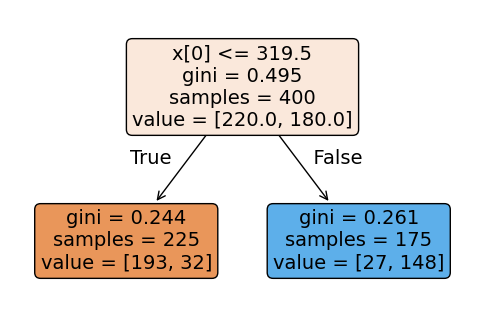

In [54]:
# Визуализация дерева глубины 1
plt.figure(figsize=(6, 4))  # Увеличиваем размер изображения
tree.plot_tree(simpler_dt_exams, rounded=True, filled=True)
plt.show()

# Создание и обучение дерева без ограничений глубины (будет переобучено)

In [55]:
crazy_dt_exams = DecisionTreeClassifier()
crazy_dt_exams.fit(exams, labels)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


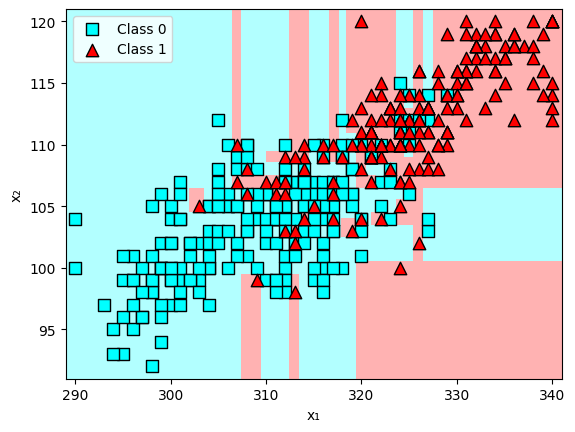

In [56]:
# Визуализация переобученной модели
plot_dt_decision_boundary(crazy_dt_exams, exams, labels)
plt.show()

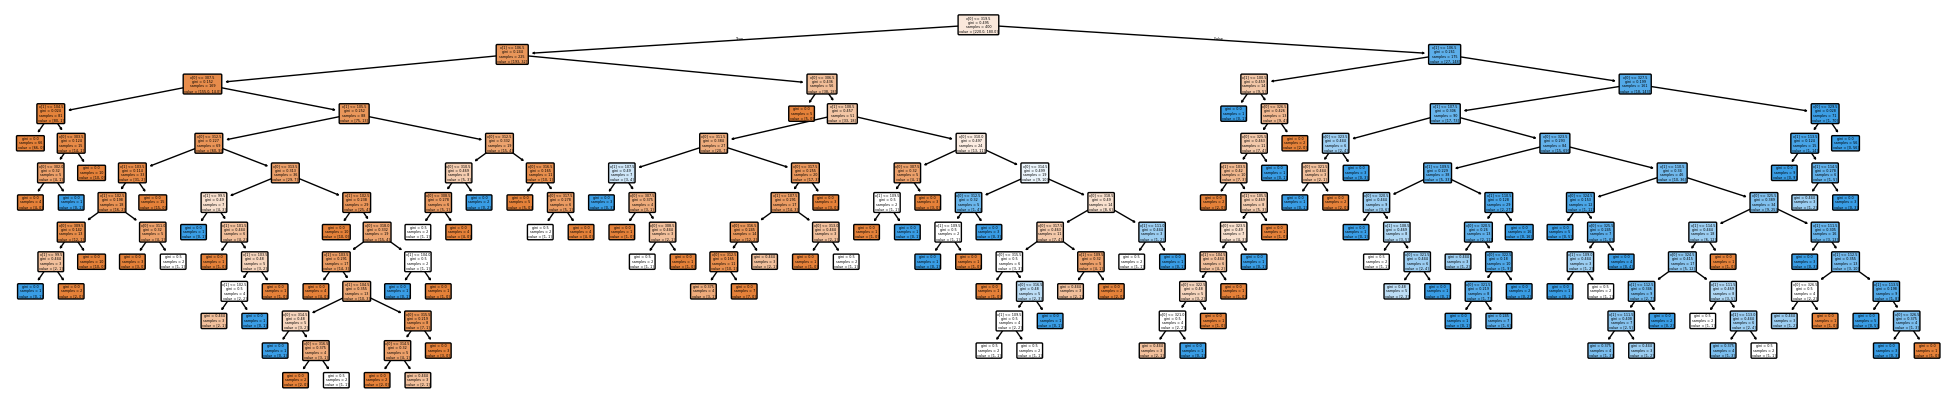

In [57]:
# Визуализация переобученного дерева
plt.figure(figsize=(25, 5))  # Увеличиваем размер изображения
tree.plot_tree(crazy_dt_exams, rounded=True, filled=True)
plt.show()

# Деревья решений для регрессии

Рассмотрим следующую проблему: у нас есть приложение, и мы хотим спрогнозировать уровень вовлеченности пользователей с точки зрения того, сколько дней в неделю они им пользовались.  
Единственный признак, которым мы располагаем, — это возраст пользователя.

In [58]:
# Создаем датасет
data = pd.DataFrame({
    'Возраст, лет': [10, 20, 30, 40, 50, 60, 70, 80],
    'Вовлеченность, дней в неделю': [7, 5, 7, 1, 2, 1, 5, 4]
})


# Выводим датасет для проверки
data

,"Возраст, лет","Вовлеченность, дней в неделю"
0,10,7
1,20,5
2,30,7
3,40,1
4,50,2
5,60,1
6,70,5
7,80,4


In [59]:
# Разделяем на признаки (features) и целевую переменную (labels)
# В этом примере будем считать "Вовлеченность" целевой переменной
features = data[['Возраст, лет']]  # Двойные скобки, чтобы получить DataFrame
labels = data['Вовлеченность, дней в неделю']  # Одинарные скобки для Series

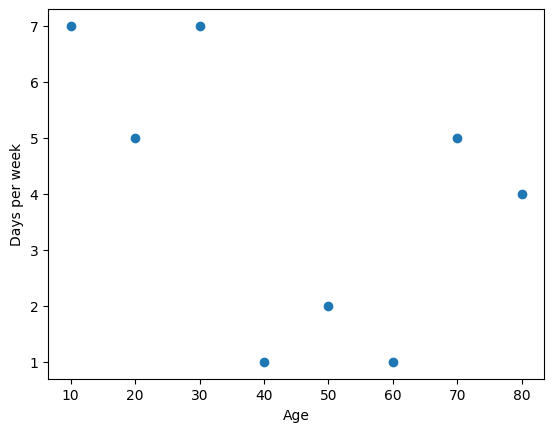

In [60]:
# Построение точечного графика зависимости целевой переменной от признака
plt.scatter(features, labels)
plt.xlabel("Age")  # Подпись оси X (Возраст)
plt.ylabel("Days per week")  # Подпись оси Y (Дней в неделю)
plt.show()  # Отображение графика

In [61]:
# Создание регрессионного дерева с максимальной глубиной 2
dt_regressor = DecisionTreeRegressor(max_depth=2)

# Обучение модели на данных (features - признаки, labels - целевые значения)
dt_regressor.fit(features, labels)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


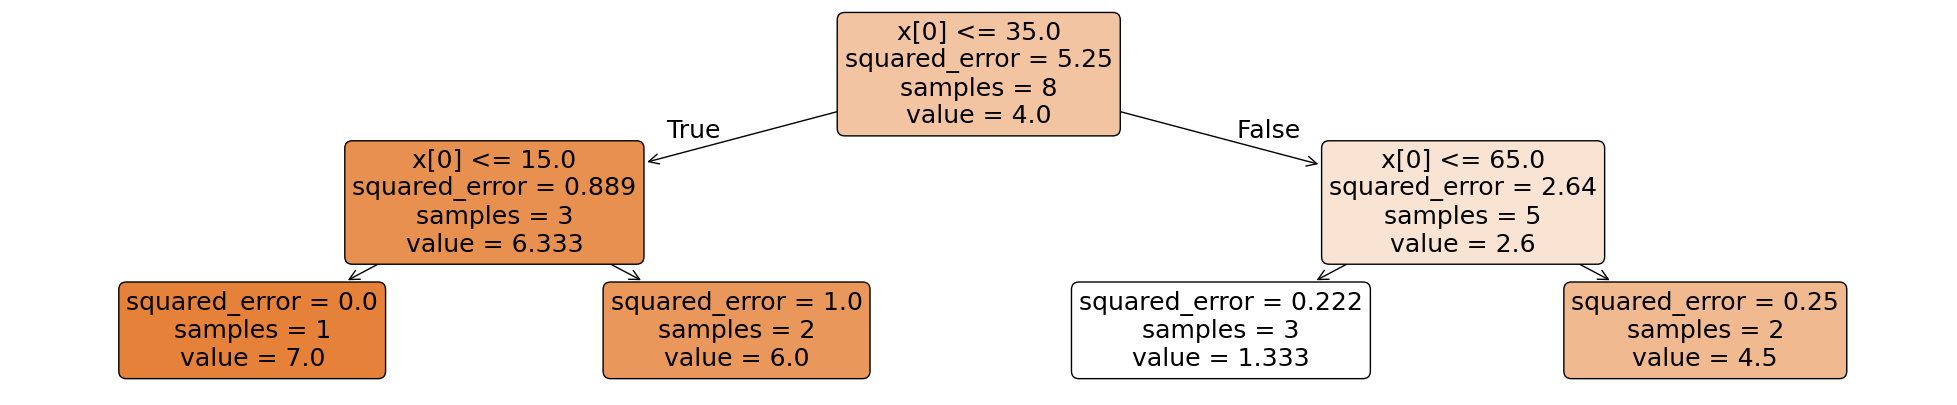

In [62]:
# Визуализация структуры дерева
plt.figure(figsize=(25, 5))  # Увеличиваем размер изображения
tree.plot_tree(dt_regressor, rounded=True, filled=True)
plt.show()

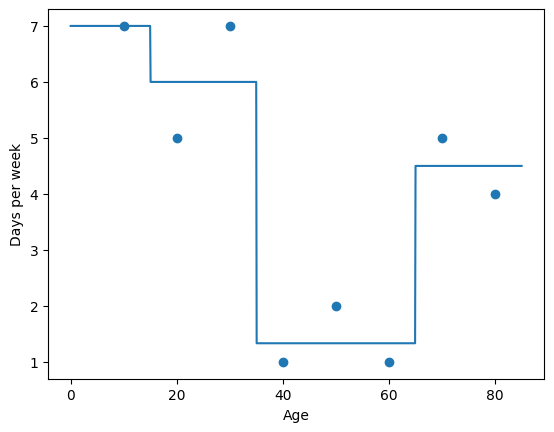

In [63]:
# Визуализация регрессионной модели (предсказаний дерева)

x = np.linspace(0,85,1000)
plt.scatter(features, labels)
plt.plot(x, dt_regressor.predict(x.reshape([-1,1])))
plt.xlabel("Age")
plt.ylabel("Days per week")
plt.show()

# Поиск оптимального первого разбиения путем минимизации MSE (среднеквадратичной ошибки)

In [64]:
results_df = evaluate_thresholds(data, 
                                 feature_col='Возраст, лет', 
                                 target_col='Вовлеченность, дней в неделю', 
                                 task='regression', 
                                 sort_by='Взвешенный MSE',
                                 precision=3
)

display(results_df)

,Вопрос,Первый набор (да),Второй набор (нет),Метки,Взвешенный MSE,Взвешенный MAE
3,"Возраст, лет < 35.0?","[10, 20, 30]","[40, 50, 60, 70, 80]","[[7, 5, 7], [1, 2, 1, 5, 4]]",1.983,1.283
2,"Возраст, лет < 25.0?","[10, 20]","[30, 40, 50, 60, 70, 80]","[[7, 5], [7, 1, 2, 1, 5, 4]]",3.917,1.750
1,"Возраст, лет < 15.0?",[10],"[20, 30, 40, 50, 60, 70, 80]","[[7], [5, 7, 1, 2, 1, 5, 4]]",3.964,1.679
4,"Возраст, лет < 45.0?","[10, 20, 30, 40]","[50, 60, 70, 80]","[[7, 5, 7, 1], [2, 1, 5, 4]]",4.250,1.750
5,"Возраст, лет < 55.0?","[10, 20, 30, 40, 50]","[60, 70, 80]","[[7, 5, 7, 1, 2], [1, 5, 4]]",4.983,2.033
6,"Возраст, лет < 65.0?","[10, 20, 30, 40, 50, 60]","[70, 80]","[[7, 5, 7, 1, 2, 1], [5, 4]]",5.167,2.000
0,"Возраст, лет < 9.0?",[],"[10, 20, 30, 40, 50, 60, 70, 80]","[[], [7, 5, 7, 1, 2, 1, 5, 4]]",5.250,2.000
7,"Возраст, лет < 75.0?","[10, 20, 30, 40, 50, 60, 70]",[80],"[[7, 5, 7, 1, 2, 1, 5], [4]]",5.250,2.000
8,"Возраст, лет < 81.0?","[10, 20, 30, 40, 50, 60, 70, 80]",[],"[[7, 5, 7, 1, 2, 1, 5, 4], []]",5.250,2.000
